In [21]:
import pandas as pd
from string import punctuation
import re
import datetime
from matplotlib.colors import LinearSegmentedColormap
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
sns.set(font_scale=0.7)

In [22]:
df1 = pd.read_csv('data/test_google_adv.csv')
df1['dt'] = pd.to_datetime(df1['dt'])
df1['dow'] = df1['dt'].dt.day_name().str.upper()
df1['hod'] = df1['dt'].dt.hour
df1.head(3)

,zip_code,dt,line_item_id,impressions,dow,hod
0,60302,2023-09-30 10:00:00,20553552908,40,SATURDAY,10
1,55901,2023-10-14 09:00:00,20553552908,92,SATURDAY,9
2,60639,2023-10-14 16:00:00,20553552908,42,SATURDAY,16


In [23]:
df2 = pd.read_csv('data/test_push_history.csv')

df2['dow_hod'] = df2['dow_hod'].apply(lambda x: x.replace(" ", ''))
df2['dow_hod'] = df2['dow_hod'].apply(lambda x: re.findall(r"\('([A-Z]+)',\((\d{1,2}),(\d{1,2})\)\)",x))
df2.head()

,line_item_id,dow_hod
0,20557215517,"[(THURSDAY, 15, 22), (FRIDAY, 15, 22), (SATURD..."
1,20553552908,"[(THURSDAY, 15, 22), (FRIDAY, 15, 22), (SATURD..."
2,20573098306,"[(MONDAY, 14, 20), (TUESDAY, 14, 20), (WEDNESD..."
3,20573186371,"[(MONDAY, 14, 17), (TUESDAY, 14, 17), (WEDNESD..."


In [24]:
plan = dict()

for i in range(df2.shape[0]):
    key = df2.loc[i,'line_item_id']
    plan[key] = dict()
    for k in df2.loc[i,'dow_hod']:
        plan[key][k[0]] = range(int(k[1]),int(k[2])+1)

plan

{20557215517: {'THURSDAY': range(15, 23),
  'FRIDAY': range(15, 23),
  'SATURDAY': range(8, 23),
  'SUNDAY': range(8, 23)},
 20553552908: {'THURSDAY': range(15, 23),
  'FRIDAY': range(15, 23),
  'SATURDAY': range(8, 23),
  'SUNDAY': range(8, 23)},
 20573098306: {'MONDAY': range(14, 21),
  'TUESDAY': range(14, 21),
  'WEDNESDAY': range(14, 21),
  'THURSDAY': range(14, 21),
  'FRIDAY': range(14, 21)},
 20573186371: {'MONDAY': range(14, 18),
  'TUESDAY': range(14, 18),
  'WEDNESDAY': range(14, 18),
  'THURSDAY': range(14, 18),
  'FRIDAY': range(14, 18)}}

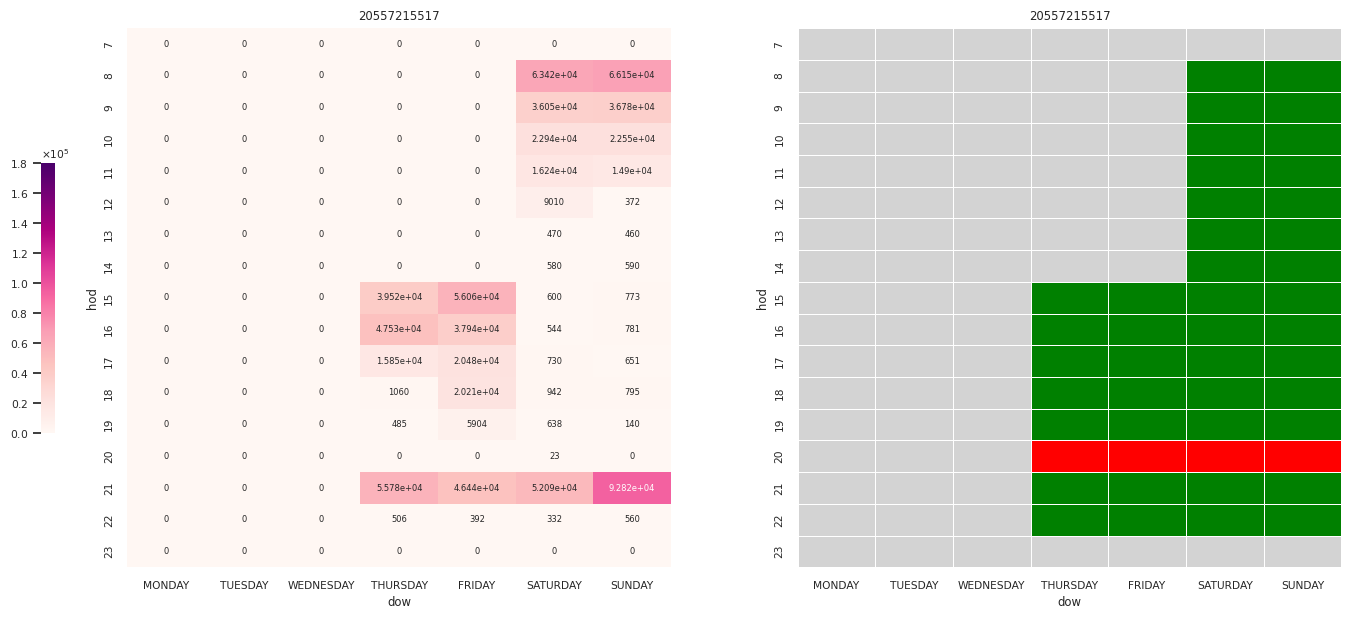

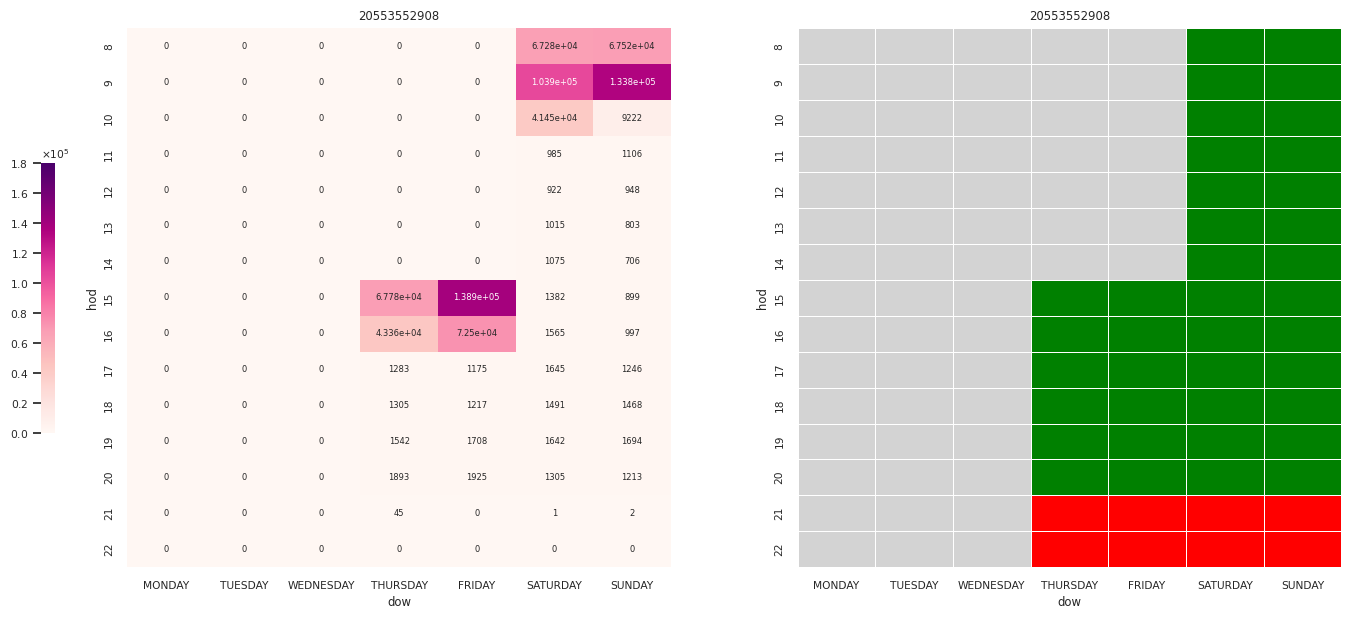

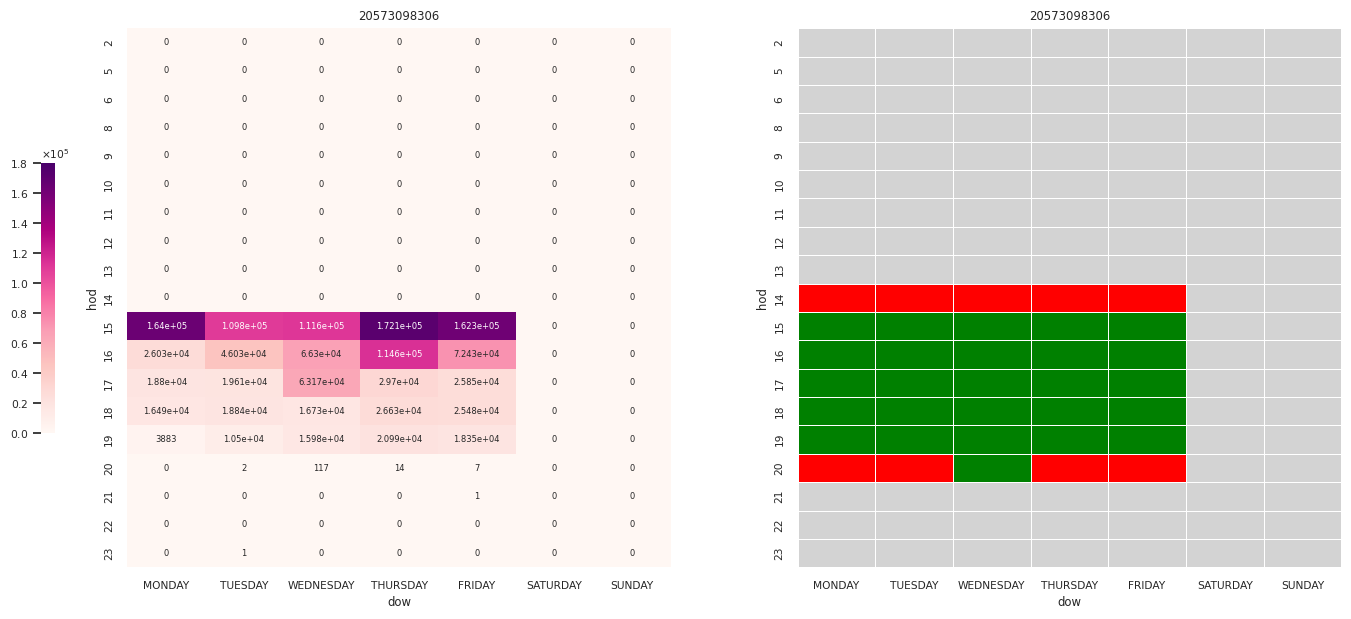

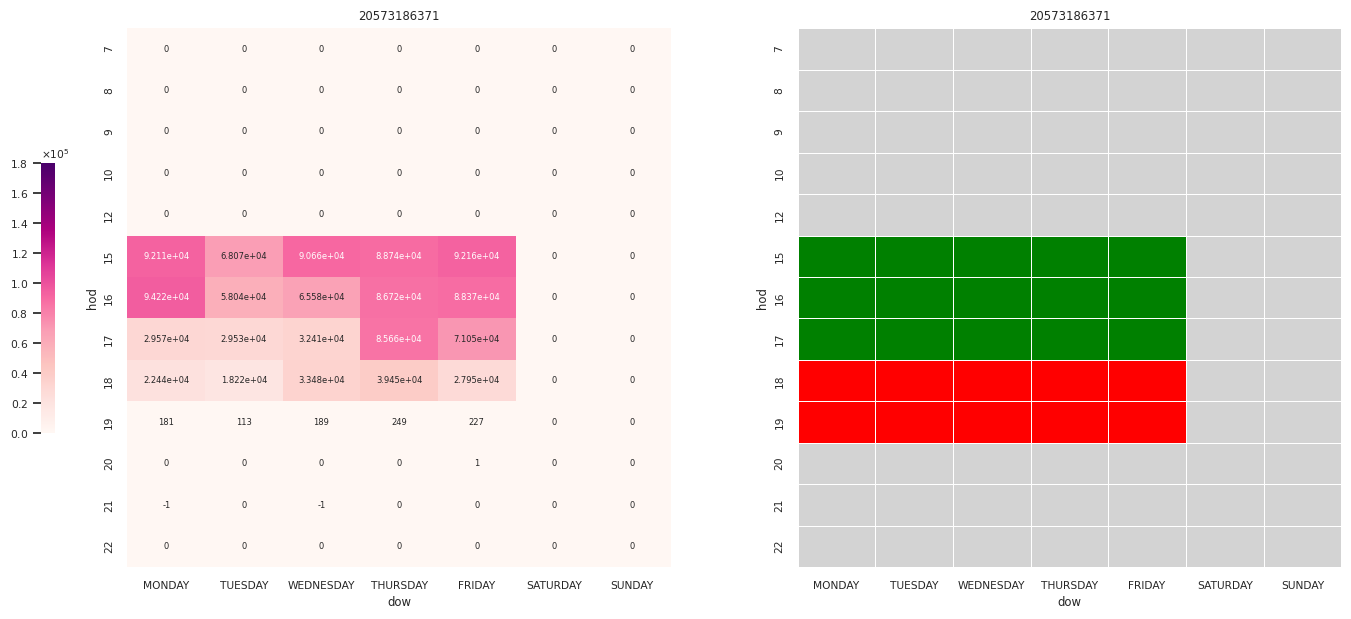

In [25]:
def get_pivots(id):
    pivot = pd.pivot_table(
        df1[(df1['line_item_id']==id)], 
        index='hod', 
        columns='dow', 
        values='impressions', 
        aggfunc='sum').fillna(0)
    col_order = [x.upper() for x in ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]
    pivot = pivot.reindex(col_order, axis=1).fillna(0)
    
    d = plan[id]
    p = pivot.T
    for i in p.index:
        for c in p.columns:
            if i not in d:
                if p.loc[i,c] >= 100:
                    p.loc[i,c] = 1
                else:
                    p.loc[i,c] = 0
                continue    
            if c in d[i] and p.loc[i,c] >= 100:
                p.loc[i,c] = 2
            elif c in d[i] and (p.loc[i,c] < 100 or math.isnan(p.loc[i,c])):
                p.loc[i,c] = 1
            elif c not in d[i] and p.loc[i,c] >= 100:
                p.loc[i,c] = 1
            else:
                p.loc[i,c] = 0
            
    
    f, a = plt.subplots(1,2, figsize=(18, 7), gridspec_kw={'width_ratios': [1, 0.75]})
    
    # 1st table
    formatter = tkr.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2,2))
    sns.heatmap(pivot,
                cmap='RdPu', 
                annot=True, 
                ax=a[0], 
                annot_kws={'fontsize':6},
                cbar_kws = {'use_gridspec':True, 'location':"left", 'shrink':0.5, 'format':formatter},
                vmin=0, vmax=180e3,
                fmt='.4g'
                ).set(title=f'{id}');
    
    # 2nd table
    colors = ['lightgray', "red", "green"] 
    cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))
    sns.heatmap(p.T, 
                cmap=cmap, 
                linewidths=.5, 
                cbar=False, 
                ax=a[1], 
                ).set(title=f'{id}');
    
    return id

for key in plan:
    get_pivots(key)
            